In [1]:
import pandas as pd

DATA_PATH = r"./data/CTG.xls"

def load_cardiotography(filepath: str):
    return pd.read_excel(filepath, sheet_name="Raw Data")

In [2]:
cardiotography = load_cardiotography(DATA_PATH)
class_labels = ['A', 'B', 'C', 'D', 'E', 'AD','DE', 'LD', 'FS', 'SUSP']

ad_columns_to_drop = ["e", "LBE", "Mean"]

cardiotography = cardiotography.drop(index=[0, 2127, 2128, 2129], columns=["FileName", "Date", "SegFile", "NSP"] + class_labels + [])

cardiotography.CLASS[:] = [int(i - 1) for i in cardiotography.CLASS]

cardiotography.head()

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS
1,240.0,357.0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,8
2,5.0,632.0,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,5
3,177.0,779.0,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,5
4,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,5
5,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_attribs = [attr for attr in cardiotography.keys() if attr != 'CLASS']

num_pipeline = Pipeline([
    ("std_scalar", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
])

In [4]:
cardiotography_prep = full_pipeline.fit_transform(cardiotography)

In [5]:
X = cardiotography_prep
y = cardiotography.CLASS

print(X.shape, y.shape)

(2126, 25) (2126,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [107]:
from tensorflow import keras


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[25]))
model.add(keras.layers.Dense(400, activation="tanh"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [108]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [109]:
import numpy as np


np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [110]:
from sklearn.utils import class_weight


class_weights = tuple(class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train
                                                )
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5650793650793651,
 1: 0.363265306122449,
 2: 4.315151515151515,
 3: 2.589090909090909,
 4: 2.966666666666667,
 5: 0.6273127753303964,
 6: 0.8736196319018404,
 7: 1.78,
 8: 2.7384615384615385,
 9: 1.1672131147540983}

In [111]:
history = model.fit(X_train, y_train, 
                    class_weight=class_weights,
                    epochs=150,
                    validation_split=0.2,
                    )

 0.5344 - accuracy: 0.7726 - val_loss: 0.6845 - val_accuracy: 0.7404
Epoch 11/150
36/36 [==============================] - 0s 2ms/step - loss: 0.5028 - accuracy: 0.7981 - val_loss: 0.6890 - val_accuracy: 0.7263
Epoch 12/150
36/36 [==============================] - 0s 2ms/step - loss: 0.4936 - accuracy: 0.7989 - val_loss: 0.6817 - val_accuracy: 0.7404
Epoch 13/150
36/36 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.8183 - val_loss: 0.6551 - val_accuracy: 0.7228
Epoch 14/150
36/36 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.8139 - val_loss: 0.6371 - val_accuracy: 0.7509
Epoch 15/150
36/36 [==============================] - 0s 2ms/step - loss: 0.4548 - accuracy: 0.8121 - val_loss: 0.6292 - val_accuracy: 0.7404
Epoch 16/150
36/36 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.8200 - val_loss: 0.6123 - val_accuracy: 0.7509
Epoch 17/150
36/36 [==============================] - 0s 2ms/step - loss: 0.438

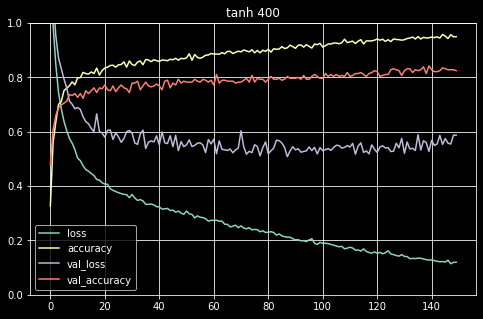

In [112]:
from matplotlib import pyplot as plt


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('tanh 400')
plt.show()

In [84]:
model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 1ms/step - loss: 0.5295 - accuracy: 0.8433


[0.5295159220695496, 0.8433048725128174]